In [109]:
# здесь только импорт
import requests, json
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import math
import urllib2
from bs4 import BeautifulSoup
import string
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits import mplot3d
import copy
from joblib import Parallel, delayed, wrap_non_picklable_objects, parallel_backend
from multiprocessing import Pool, cpu_count
from tqdm import tqdm_notebook
from fake_useragent import UserAgent
import re

In [110]:
# посылаем запросы через хост ТОРа
import socks
import socket
socks.set_default_proxy(socks.SOCKS5, "localhost", 9150)
socket.socket = socks.socksocket

In [111]:
# если вдруг захочется проверить свой IP
def checkIP():
    ip = requests.get('http://checkip.dyndns.org').content
    soup = BeautifulSoup(ip, 'html.parser')
    print(soup.find('body').text)

checkIP()

Current IP Address: 54.37.204.183


In [112]:
# функция парсинга объектов постранично
def parsing_new(i):
    try:
        response = requests.get('https://www.domofond.ru/prodazha-kvartiry-samara-c2415?ApartmentSaleType=Resale&Page=' + str(i), headers={'User-Agent': UserAgent().chrome})
        html = response.content
        soup = BeautifulSoup(html,'html.parser')
        string_soup = str(soup)

        indexes = [m.start() for m in re.finditer('itemUrl', string_soup)]
        for j in range(len(indexes)):
            index_finish = string.find(string_soup[(indexes[j]+11):], ',')
            hrefs = string_soup[(indexes[j]+11):(indexes[j]+10+index_finish)]
            clean_hrefs = 'https://www.domofond.ru/' + hrefs
            our_links.append(clean_hrefs)
    except:
        null

In [113]:
# функция парсинга для одной ссылки
def parse_single_flat(i):
    try:
        # забираем стоимость квадратного метра

        response = requests.get(our_links[i])
        html = response.content
        soup = BeautifulSoup(html,'html.parser')
        soup_str = str(soup)
        index_start = string.find(soup_str, '"Цена за м²","value"')
        index_finish = string.find(soup_str[index_start+30:], '₽')
        sq_m_price_str = soup_str[(index_start+30):(index_start+30+index_finish)]
        sq_m_price_str = sq_m_price_str.replace(' ', '')
        try:
            sq_m_price = float(sq_m_price_str)
        except:
            sq_m_price = None

        # забираем координаты объекта (широта и долгота)
        try:
            str_start = string.find(soup_str, 'longitude') + 11
            str_finish = string.find(soup_str, 'latitude') - 2
            coord_1 = float(soup_str[str_start:str_finish])
        except:
            coord_1 = None

        try:
            str_start = string.find(soup_str, 'latitude') + 10
            str_finish = string.find(soup_str, 'latitude') + 18
            coord_2 = float(soup_str[str_start:str_finish])
        except:
            coord_2 = None

        dataset_flats.loc[i, 'lng'] = coord_1
        dataset_flats.loc[i, 'lat'] = coord_2
        dataset_flats.loc[i, 'sq_meter_price'] = sq_m_price
    except:
        dataset_flats.loc[i, 'lng'] = None
        dataset_flats.loc[i, 'lat'] = None
        dataset_flats.loc[i, 'sq_meter_price'] = None

In [118]:
# собираем ссылки на квартиры

our_links = list()

with parallel_backend('threading', n_jobs = 8):
    Parallel()(delayed(parsing_new)(m) for m in tqdm_notebook(range(292)))

In [119]:
# заносим список в датасет
dataset_flats = pd.DataFrame(our_links, columns=['link'])

In [120]:
# ходим по ссылкам на квартиры и собираем геопозицию и цену квадратного метра

with parallel_backend('threading', n_jobs = 8):
    Parallel()(delayed(parse_single_flat)(m) for m in tqdm_notebook(range(len(our_links))))

In [121]:
# визуалзируем данные
dataset_flats.loc[dataset_flats['lng'] > 53, 'lng'] = None
dataset_flats.loc[dataset_flats['lng'] < 49.5, 'lng'] = None
x_data = dataset_flats.dropna()['lng']
y_data = dataset_flats.dropna()['lat']
z_data = dataset_flats.dropna()['sq_meter_price'].sort_values(ascending = True)

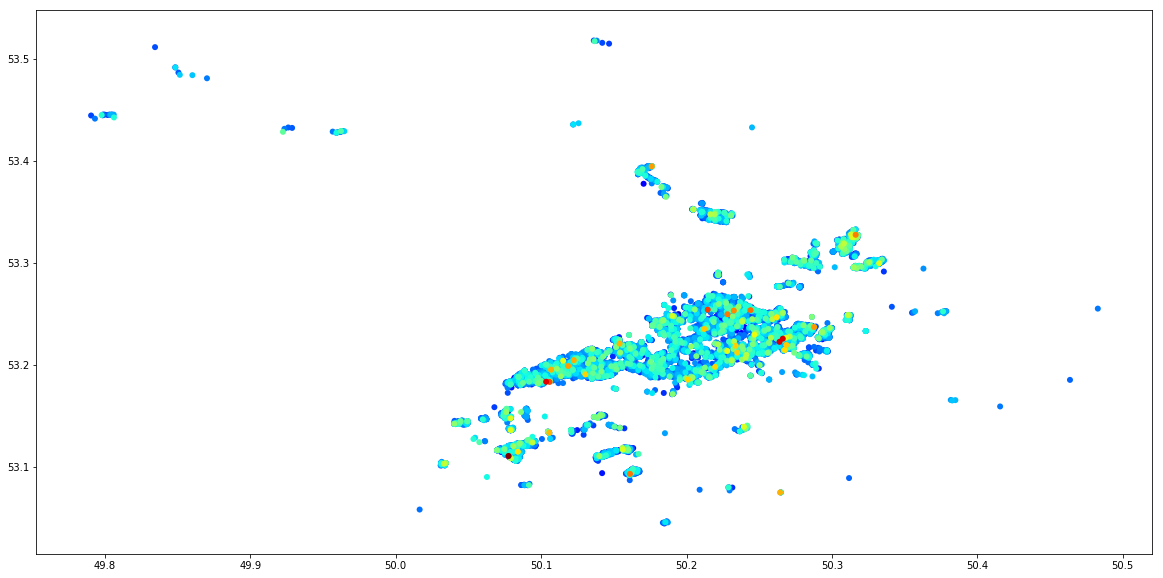

In [122]:
# посмотрим на плоскости, размер кружочка соответствует цене
plt.figure(figsize=(20,10))
plt.scatter(x_data, y_data, marker = 'o',
                   c =  z_data,
                   cmap=cm.jet,
                   linewidths = 0)

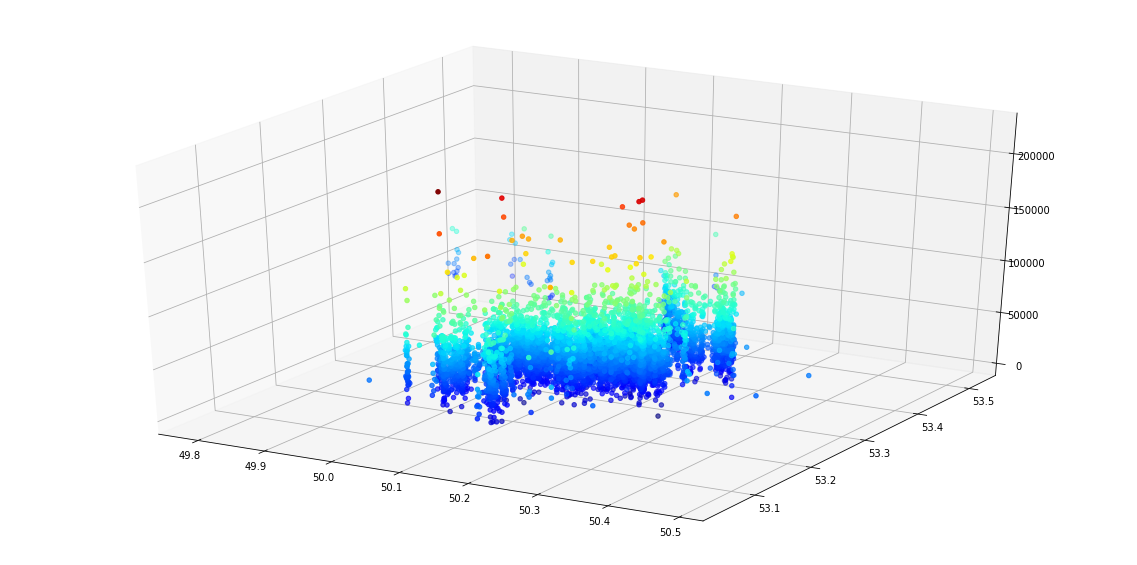

In [123]:
# попробуем посмотреть 3D
plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')
ax.scatter(x_data, y_data, z_data, c=z_data, cmap=cm.jet, marker='o')

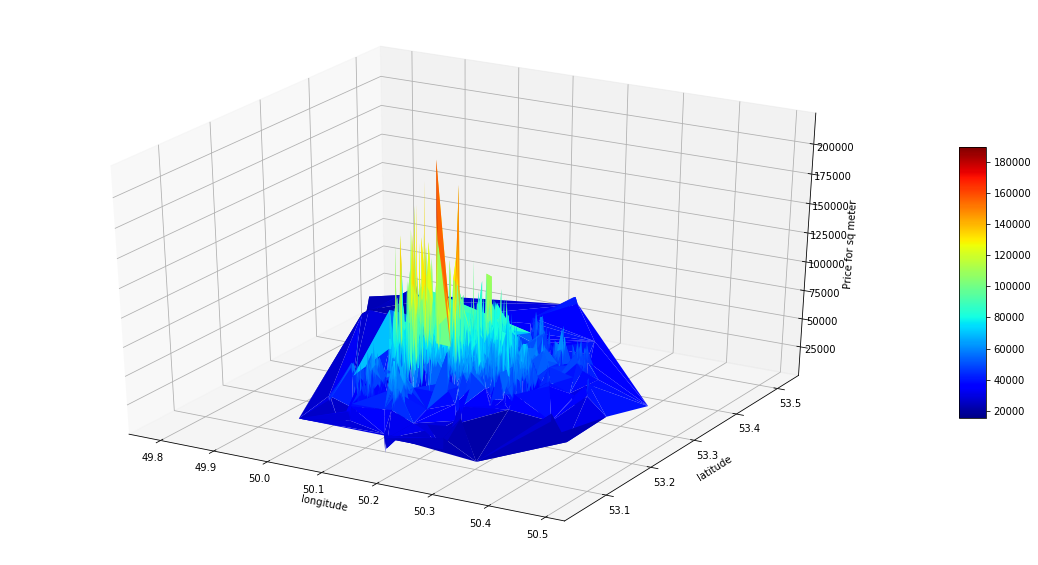

In [124]:
# построим поверхность
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_zlabel('Price for sq meter')
#ax.plot_wireframe(cParams, gammas, avg_errors_array)
#ax.plot3D(cParams, gammas, avg_errors_array)
#ax.scatter3D(cParams, gammas, avg_errors_array, zdir='z',cmap='viridis')

df = pd.DataFrame({'x': x_data, 'y': y_data, 'z': z_data})
surf = ax.plot_trisurf(df.x, df.y, df.z, cmap=cm.jet, linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=10)    
#ax.view_init(90, 90)
plt.show()

In [125]:
# посмотрим на квартиры только в Самаре
samara_only = copy.deepcopy(dataset_flats)
samara_only.loc[samara_only['lng'] < 49.6, 'lng'] = None
x_data_s = samara_only.dropna()['lng']
y_data_s = samara_only.dropna()['lat']
z_data_s = samara_only.dropna()['sq_meter_price'].sort_values()

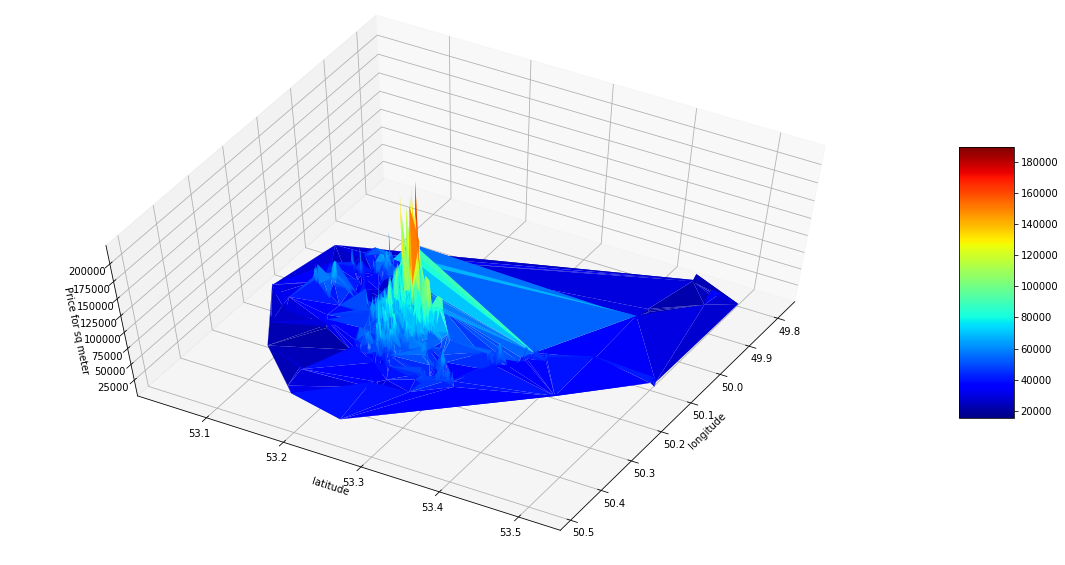

In [126]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_zlabel('Price for sq meter')
#ax.plot_wireframe(cParams, gammas, avg_errors_array)
#ax.plot3D(cParams, gammas, avg_errors_array)
#ax.scatter3D(cParams, gammas, avg_errors_array, zdir='z',cmap='viridis')

df = pd.DataFrame({'x': x_data_s, 'y': y_data_s, 'z': z_data_s})
surf = ax.plot_trisurf(df.x, df.y, df.z, cmap=cm.jet, linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)    
ax.view_init(60, 30)
plt.show()

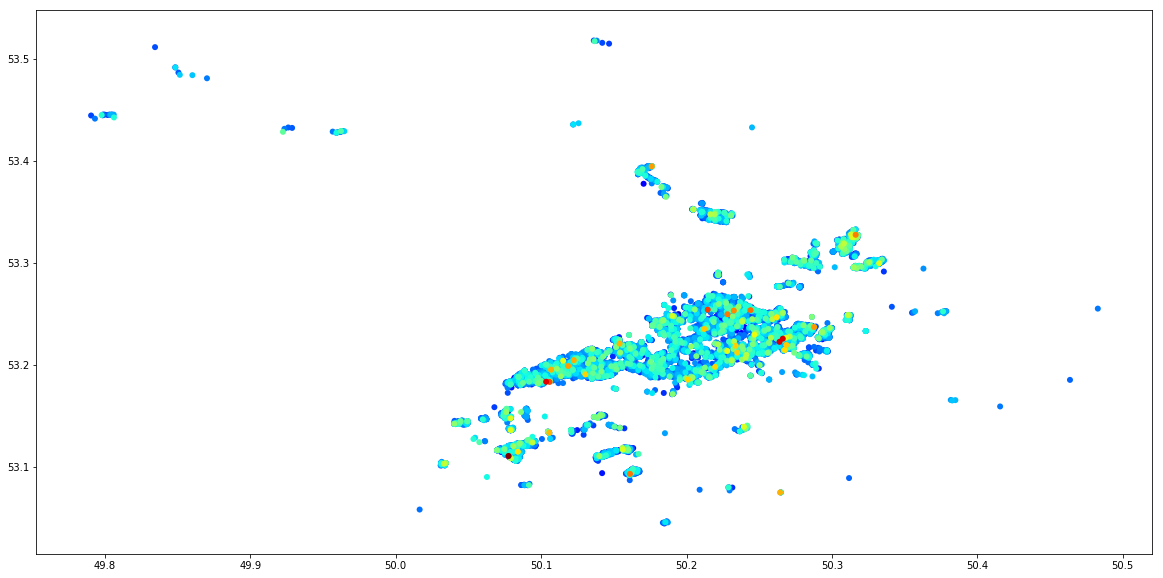

In [127]:
plt.figure(figsize=(20,10))
plt.scatter(x_data_s, y_data_s, marker = 'o',
                   c =  z_data_s,
                   cmap=cm.jet,
                   linewidths = 0)

In [128]:
# Элементы машинного обучения

In [129]:
# Линейная регрессия

from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

samara_only_dropped = samara_only.dropna()
X = samara_only_dropped[['lng', 'lat']].values
y = samara_only_dropped[['sq_meter_price']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regressor = LinearRegression()  
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

df_lr = pd.DataFrame({'Actual': y_test.ravel(), 'Predicted': y_pred.ravel()})

In [152]:
df_lr.head(15)

,Actual,Predicted
0,20952.0,80009.458370
1,58704.0,56616.278620
2,60891.0,57176.923593
3,66116.0,55669.316221
4,43182.0,61257.109304
5,82500.0,62286.662261
6,63559.0,60699.684582
7,51163.0,56343.579988
8,52805.0,58009.032095
9,53905.0,55637.890440


In [162]:
X

array([[50.286567, 53.23265 ],
       [50.116623, 53.20028 ],
       [50.095639, 53.19443 ],
       ...,
       [50.263952, 53.22237 ],
       [50.266202, 53.22544 ],
       [50.077606, 53.11037 ]])

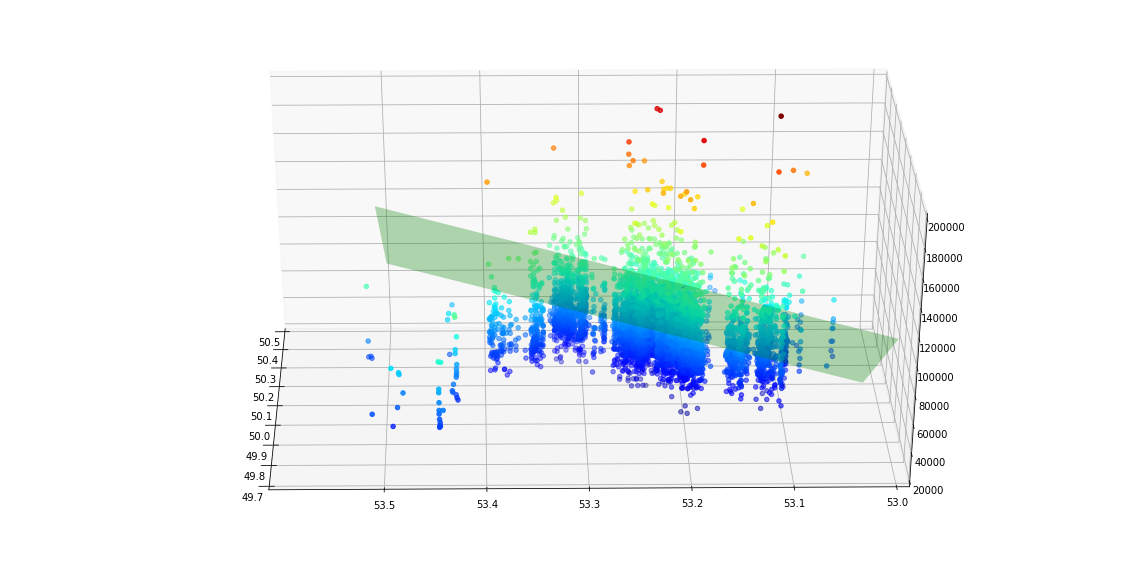

In [246]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import scipy.optimize
import functools
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

def plane(x, y, params):
    a = params[0]
    b = params[1]
    c = params[2]
    z = a*x + b*y + c
    return z

def error(params, points):
    result = 0
    for (x,y,z) in points:
        plane_z = plane(x, y, params)
        diff = abs(plane_z - z)
        result += diff**2
    return result

def cross(a, b):
    return [a[1]*b[2] - a[2]*b[1],
            a[2]*b[0] - a[0]*b[2],
            a[0]*b[1] - a[1]*b[0]]

points = [(50.28657,53.23265,48849.43),
          (50.11662,53.20028,99812.79),
          (50.09564,53.19443,66533.64)]

fun = functools.partial(error, points=points)
params0 = [0, 0, 0]
res = scipy.optimize.minimize(fun, params0)

a = res.x[0]
b = res.x[1]
c = res.x[2]

xs, ys, zs = zip(*points)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs, ys, zs)

point  = np.array([0.0, 0.0, c])
normal = np.array(cross([1,0,a], [0,1,b]))
d = -point.dot(normal)
xx, yy = np.meshgrid([49.8,50.4], [53,53.5])
z = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]
ax.plot_surface(xx, yy, z, alpha=0.3, color=[0,1,0])
ax.scatter(x_data, y_data, z_data, c=z_data, cmap=cm.jet, marker='o')

ax.set_xlim(49.7,50.5)
ax.set_ylim(53,53.6)
ax.set_zlim(20000,200000)

for k in range(180):
    ax.view_init(30, k)
    plt.savefig('png/testplot' + str(k) + '.png')

plt.show()

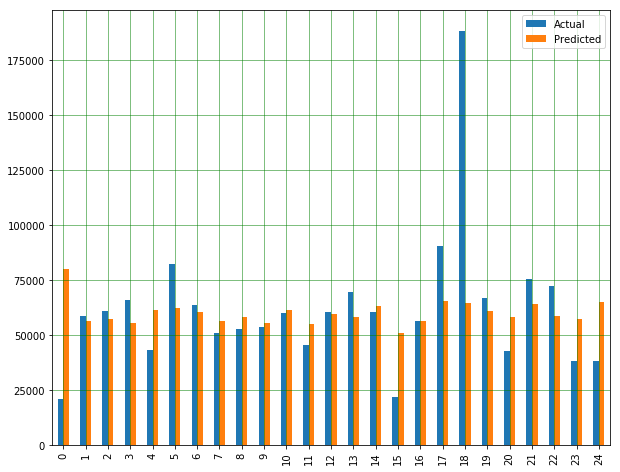

In [131]:
df_lr.head(25).plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [132]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('Mean Absolute Error:', 14473.458707425918)
('Mean Squared Error:', 403767289.67395705)
('Root Mean Squared Error:', 20093.961522655434)


In [133]:
# Случайный лес

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(X_train, y_train.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [134]:
predictions = rf.predict(X_test)

In [135]:
df_rf = pd.DataFrame({'Actual': y_test.ravel(), 'Predicted': predictions.ravel()})

In [136]:
df_rf.head(15)

,Actual,Predicted
0,20952.0,20072.967000
1,58704.0,70241.851255
2,60891.0,57871.410824
3,66116.0,52472.332038
4,43182.0,34606.871000
5,82500.0,74878.817450
6,63559.0,83668.693847
7,51163.0,50738.832033
8,52805.0,63245.172522
9,53905.0,61705.901521


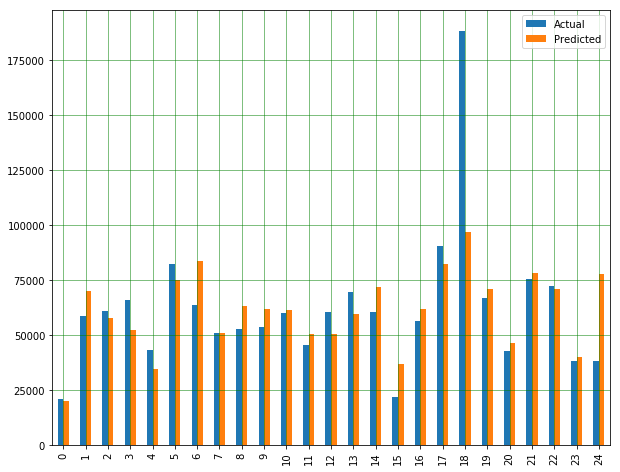

In [137]:
df_rf.head(25).plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [138]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

('Mean Absolute Error:', 9174.872113695148)
('Mean Squared Error:', 173425666.30261785)
('Root Mean Squared Error:', 13169.117901462416)


In [139]:
all_predictions = rf.predict(X)
pred_table = pd.DataFrame({'Actual': y.ravel(), 'Predicted': all_predictions.ravel()})
pred_table.to_excel('pred_table.xlsx')

In [140]:
samara_only_dropped.to_excel('dropped_table.xlsx')

In [141]:
samara_only_dropped = samara_only_dropped.reset_index(drop = True)
samara_only_dropped['Predicted'] = pred_table['Predicted']

In [142]:
samara_only_dropped['Discount'] = (samara_only_dropped['Predicted'] - samara_only_dropped['sq_meter_price']) / samara_only_dropped['Predicted']

In [143]:
list_of_k = list()
for j in range(101):
    k = 0
    for i in range(len(samara_only_dropped)):
        if (samara_only_dropped.loc[i, 'Discount'] < (float(j)/100)) & (samara_only_dropped.loc[i, 'Discount'] > (-float(j)/100)):
            k = k+1
    list_of_k.append(100 * float(k) / len(samara_only_dropped))

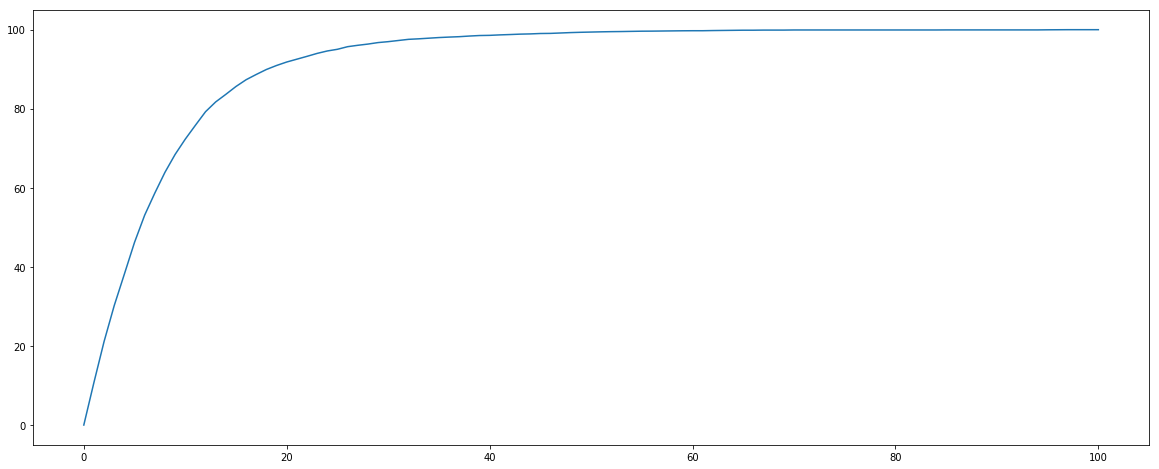

In [144]:
plt.figure(figsize=(20,8))
plt.plot(list_of_k)